In [4]:
import numpy as np
import panadas as pd
import matplotlib.pyplot as plt
import yfinance as yf

import torch
import torch.nn as nn
import torch.optim as optim


from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error

In [5]:
#use GPU for computing if not the CPu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


In [6]:
# use ticker symbola e.g(AAPL) to identify sotcks
ticker = 'AAPL'
# accessing data relating to stock as initalized above
df = yf.download(ticker, '2020-01-01')

[*********************100%***********************]  1 of 1 completed


<Axes: xlabel='Date'>

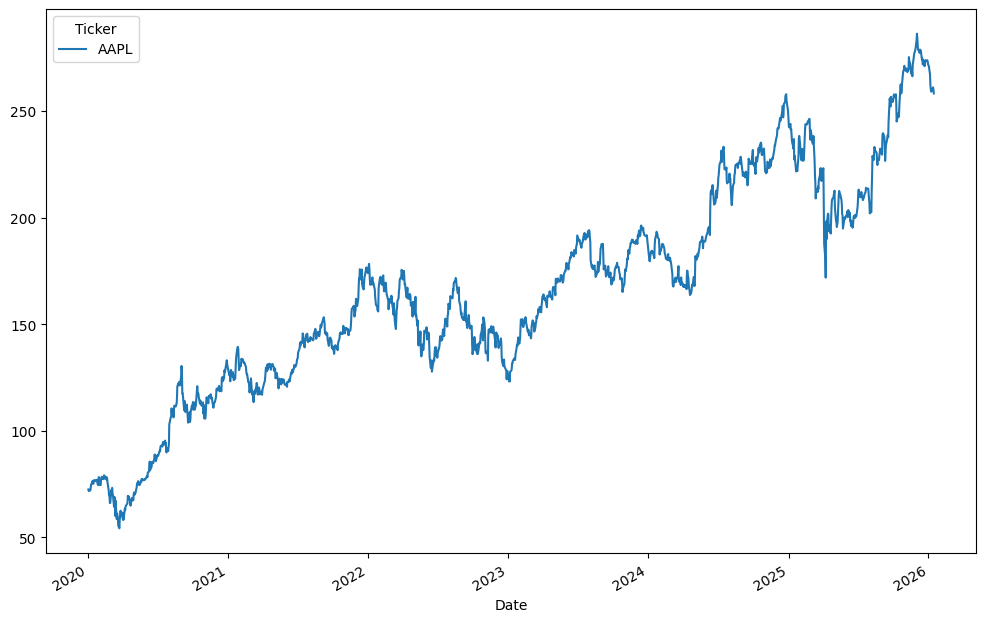

In [7]:
# prints chart
df.Close.plot(figsize=(12, 8))

In [8]:
#set the data scaling type
scaler = StandardScaler()
# scale all data
df['Close'] = scaler.fit_transform(df['Close'])

In [9]:
df.Close

Ticker,AAPL
Date,
2020-01-02,-1.856445
2020-01-03,-1.870492
2020-01-06,-1.859091
2020-01-07,-1.865873
2020-01-08,-1.842783
...,...
2026-01-09,1.869958
2026-01-12,1.887503
2026-01-13,1.903453


In [10]:
# set the amount of data to look at
seq_length = 60
data = []
# iterate previous stock data into array based on seq_length
for i in range(len(df) - seq_length):
    data.append(df.Close[i:i+seq_length])
#add array to numpy
data = np.array(data)
#training data set size (80% train 20% predict)
train_size = int(0.8 * len(data))
#train the NN on data except for the last piece which we will predict
X_train = torch.from_numpy(data[:train_size, :-1, :]).type(torch.Tensor).to(device)
#only trains the last element 
y_train = torch.from_numpy(data[:train_size, -1, :]).type(torch.Tensor).to(device)
# test the sequence set for correct predictions
X_test = torch.from_numpy(data[train_size:, :-1, :]).type(torch.Tensor).to(device)
#test last data point prediction 
y_test = torch.from_numpy(data[train_size:, -1, :]).type(torch.Tensor).to(device)
#this creates tensors with the sequence data

In [12]:
# create an object to predict inheriting from pytorch NN
class PredictionModel(nn.Module):

    def __init__ (self, input_dim, hidden_dim, num_layers, output_dim):
        #initalizes the prediction modle
        super(PredictionModel, self).__init__()
        # this is the number of layers of neurons in our nerual netowrk
        self.num_layers = num_layers
        # the hidden dimesnsion count
        self.hidden_dim = hidden_dim
        #set the number of neruons per layer and number of layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        #P.S reaserch LSTM's 
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        #lost the plot
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)

        out, (hn,cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:,-1,:])

        return out
        

In [13]:
# creates an instance of the class setting the parameters and sending it to device
model = PredictionModel(input_dim=1, hidden_dim=32, num_layers=2, output_dim=1).to(device)

In [14]:
#switch to price points
criterion = nn.MSELoss()
#optimizes model during the training
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [15]:
num_epochs = 200

for i in range(num_epochs):
    #caculate losses
    y_train_pred = model(X_train)
    loss = criterion(y_train_pred, y_train)

    if i%25 == 0:
        print(i, loss)
    # optmimze model based on loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    

0 tensor(0.5955, grad_fn=<MseLossBackward0>)
25 tensor(0.0122, grad_fn=<MseLossBackward0>)
50 tensor(0.0053, grad_fn=<MseLossBackward0>)
75 tensor(0.0047, grad_fn=<MseLossBackward0>)
100 tensor(0.0043, grad_fn=<MseLossBackward0>)
125 tensor(0.0040, grad_fn=<MseLossBackward0>)
150 tensor(0.0038, grad_fn=<MseLossBackward0>)
175 tensor(0.0035, grad_fn=<MseLossBackward0>)


In [22]:
# Sets to eval mode
model.eval()

# Get predictions
y_train_pred = model(X_train)
y_test_pred = model(X_test)

# Convert from tensors to numpy and inverse transform - DETACH FIRST
y_train_pred_np = scaler.inverse_transform(y_train_pred.detach().cpu().numpy())
y_train_np = scaler.inverse_transform(y_train.detach().cpu().numpy())

y_test_pred_np = scaler.inverse_transform(y_test_pred.detach().cpu().numpy())
y_test_np = scaler.inverse_transform(y_test.detach().cpu().numpy().reshape(-1, 1))

In [23]:
train_rmse = root_mean_squared_error(y_train_np[:, 0], y_train_pred_np[:, 0])
test_rmse = root_mean_squared_error(y_test_np[:, 0], y_test_pred_np[:, 0])

In [24]:
train_rmse

2.999866008758545

In [25]:
test_rmse

10.244388580322266

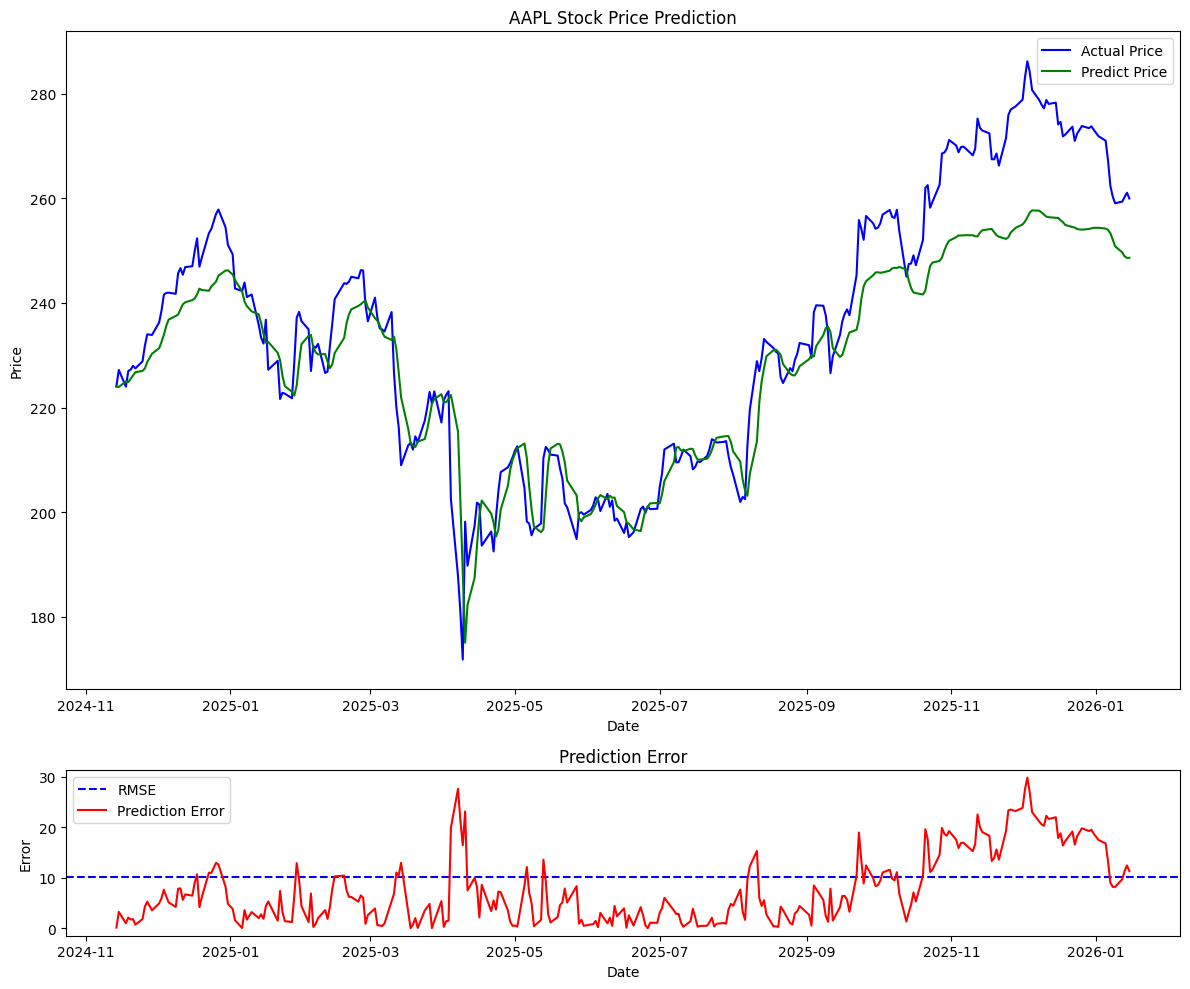

In [27]:
fig = plt.figure(figsize=(12,10))

gs = fig.add_gridspec(4,1)

ax1 = fig.add_subplot(gs[:3,0])
ax1.plot(df.iloc[-len(y_test):].index, y_test_np, color='blue', label = 'Actual Price')
ax1.plot(df.iloc[-len(y_test):].index, y_test_pred_np, color='green', label = 'Predict Price')
ax1.legend()
plt.title(f"{ticker} Stock Price Prediction")
plt.xlabel('Date')
plt.ylabel('Price')

ax2 = fig.add_subplot(gs[3,0])
ax2.axhline(test_rmse, color='blue', linestyle='--', label='RMSE')
ax2.plot(df.iloc[-len(y_test):].index, abs(y_test_np[:, 0] - y_test_pred_np[:, 0]), 'r', label = 'Prediction Error')
ax2.legend()
plt.title('Prediction Error')
plt.xlabel('Date')
plt.ylabel('Error')
plt.tight_layout()
plt.show()